# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.75KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

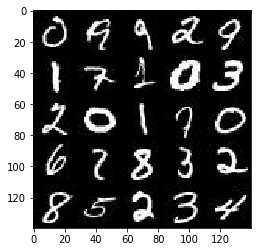

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

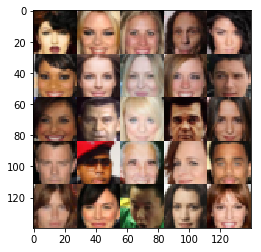

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, (None), name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [81]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("discriminator", reuse=reuse):
        
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        
        flatten = tf.reshape(x, (-1, 4*4*256)) 
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [89]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, padding="same")
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [66]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    _, d_logits_real = discriminator(input_real, reuse=False)
    gen = generator(input_z, out_channel_dim, is_train=True)
    d_out_fake, d_logits_fake = discriminator(gen, reuse=True)
    
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real)*(1-smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    
    _, l, w, c = data_shape
    input_real, input_z, _ = model_inputs(l, w, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_train_opt , g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    idx = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                idx += 1 

                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if idx % 10 == 0 : 
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if idx % 100 == 0 : 
                    show_generator_output(sess, 25, input_z, c, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7345... Generator Loss: 1.5777
Epoch 1/2... Discriminator Loss: 1.8801... Generator Loss: 0.3282
Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 2.3200
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.5441
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.5319
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.8816
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 1.3859
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 1.4267
Epoch 1/2... Discriminator Loss: 0.9605... Generator Loss: 1.2987


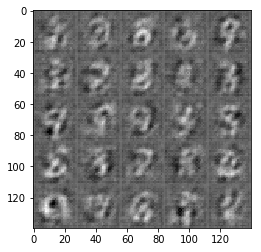

Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 1.8053
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 1.5501
Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 1.4360
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.5467
Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 1.0029
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.3361
Epoch 1/2... Discriminator Loss: 0.8917... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 2.2856
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 1.1426


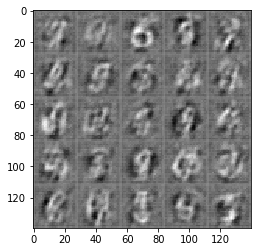

Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 3.2471
Epoch 1/2... Discriminator Loss: 0.8043... Generator Loss: 1.4532
Epoch 1/2... Discriminator Loss: 0.7642... Generator Loss: 1.3106
Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 2.1378
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 0.6951... Generator Loss: 1.7871
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.4703
Epoch 1/2... Discriminator Loss: 0.7265... Generator Loss: 1.6171
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 1.6387


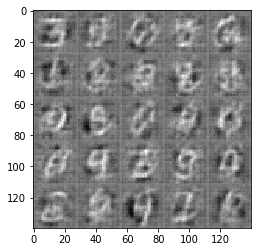

Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.4123
Epoch 1/2... Discriminator Loss: 0.9316... Generator Loss: 1.3233
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.3444
Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 2.4524
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 1.7104
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 0.7698


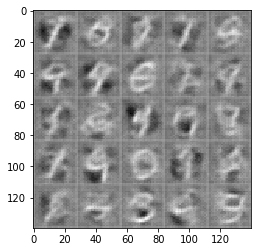

Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 1.5841
Epoch 1/2... Discriminator Loss: 2.0204... Generator Loss: 0.2768
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 1.7239
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 0.9439
Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 1.4645
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.4418
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 0.7666


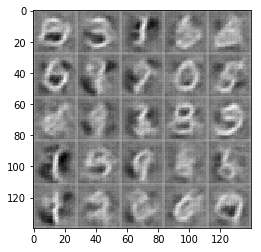

Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.9744
Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 2.6656
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 1.5106
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 2.2242
Epoch 1/2... Discriminator Loss: 1.0079... Generator Loss: 1.5508
Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 2.7261
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 0.9037
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 0.8562
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 0.6996


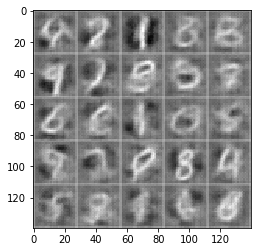

Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 1.1809
Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 0.8652
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.9651
Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 0.9118... Generator Loss: 1.1275
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 1.2683
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.4168
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 1.8212
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 0.9727
Epoch 1/2... Discriminator Loss: 0.7215... Generator Loss: 1.7049


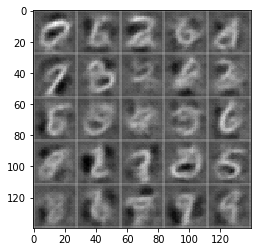

Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 0.9960
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 1.0426
Epoch 1/2... Discriminator Loss: 0.8959... Generator Loss: 2.2799
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 2.6085
Epoch 1/2... Discriminator Loss: 0.9220... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 0.6929... Generator Loss: 1.8767
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.5137
Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 1.4581
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.5530


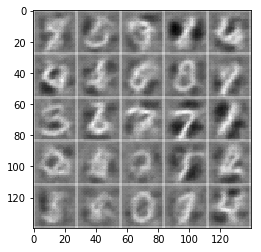

Epoch 1/2... Discriminator Loss: 0.9829... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 3.2709
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.3287
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 0.8148... Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 0.8630... Generator Loss: 1.0880
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.0026
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.5761
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.1691
Epoch 1/2... Discriminator Loss: 0.9830... Generator Loss: 1.8276


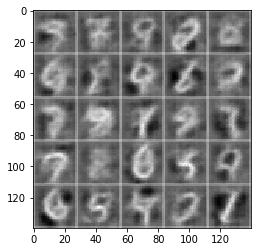

Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 1.5909
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.2682
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 1.2980
Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 1.4461
Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 1.5333
Epoch 2/2... Discriminator Loss: 1.5640... Generator Loss: 0.4386


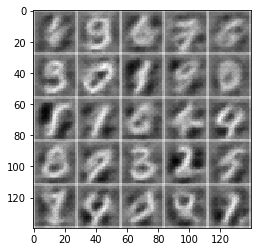

Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.1340
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 1.8543
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 1.0844
Epoch 2/2... Discriminator Loss: 0.9009... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 1.7754... Generator Loss: 0.4543
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 0.8214
Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.2890
Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.7219
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.6662
Epoch 2/2... Discriminator Loss: 0.8330... Generator Loss: 1.1720


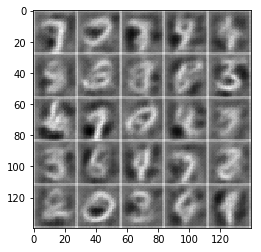

Epoch 2/2... Discriminator Loss: 0.7312... Generator Loss: 1.6845
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 2.1418
Epoch 2/2... Discriminator Loss: 0.8842... Generator Loss: 2.1191
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.2007
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.6500
Epoch 2/2... Discriminator Loss: 0.8643... Generator Loss: 1.5617
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.0318
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.0823


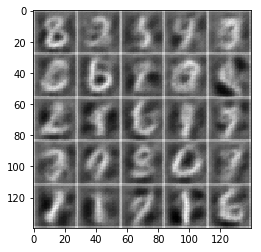

Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 0.8149
Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 1.6699... Generator Loss: 0.4063
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.1781
Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 1.1394
Epoch 2/2... Discriminator Loss: 0.7850... Generator Loss: 2.2226
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 1.0960
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 1.7963
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 1.9151
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 1.3356


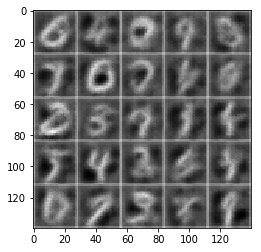

Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 1.3801
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.5936
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 2.0678
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.4395
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 1.5001
Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 0.8717
Epoch 2/2... Discriminator Loss: 0.7393... Generator Loss: 1.7072
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.3126


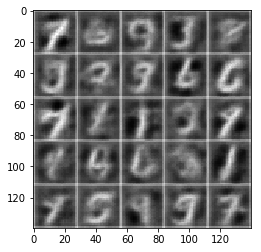

Epoch 2/2... Discriminator Loss: 0.8473... Generator Loss: 1.1660
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 1.5476
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 1.6036
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.6436
Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 1.8818
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.3379
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.9127
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 2.3945
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.1370


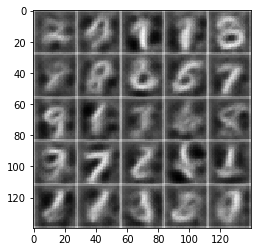

Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.9056
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.1823
Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 1.2122
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.4518
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 1.0079
Epoch 2/2... Discriminator Loss: 0.9027... Generator Loss: 1.0283
Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.7547
Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 0.7618


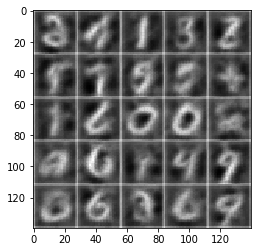

Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.6684
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.0608
Epoch 2/2... Discriminator Loss: 0.6593... Generator Loss: 1.9160
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.4444
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.0207
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 2.1404
Epoch 2/2... Discriminator Loss: 0.7581... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 1.7741
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 1.5322
Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.8834


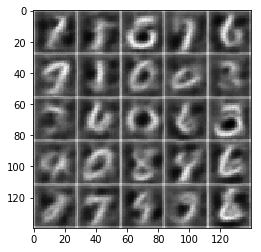

Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 1.4803
Epoch 2/2... Discriminator Loss: 0.9201... Generator Loss: 1.0490
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 2.0070
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 1.8684
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.7219
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.4049
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.3208
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.9621


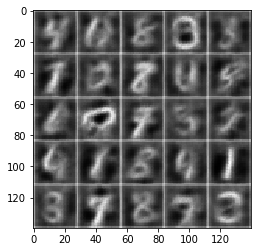

Epoch 2/2... Discriminator Loss: 0.8031... Generator Loss: 1.1986
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.1743
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.1951
Epoch 2/2... Discriminator Loss: 0.7407... Generator Loss: 1.4025
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 2.0423
Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 1.9946
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.9471


IndexError: list index out of range

In [90]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 10.2586
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 2.3533
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 2.3339
Epoch 1/1... Discriminator Loss: 0.6034... Generator Loss: 2.4534
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 4.6156
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 4.9449
Epoch 1/1... Discriminator Loss: 3.6619... Generator Loss: 8.2989
Epoch 1/1... Discriminator Loss: 1.9276... Generator Loss: 0.2879
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.8323


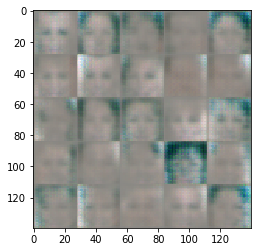

Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.7123... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 1.1745


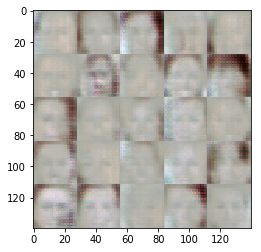

Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.2568
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.9691


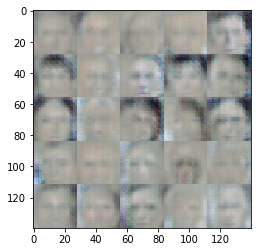

Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 2.3907... Generator Loss: 0.1836
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.9070


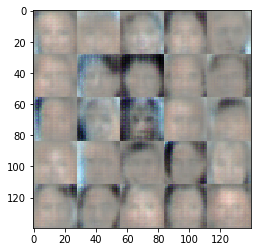

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.5212
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.8954
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 1.0126


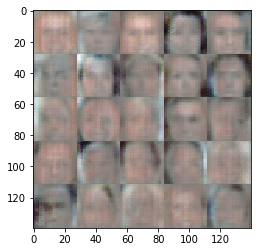

Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7764


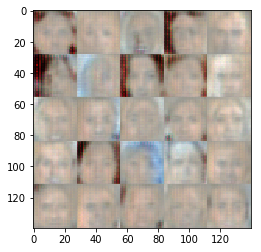

Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 1.2525
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.9060


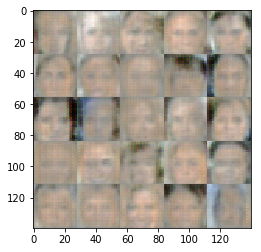

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.1186
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9280


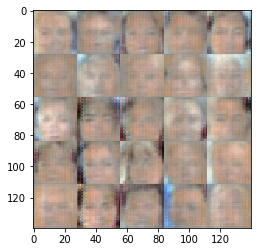

Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8434


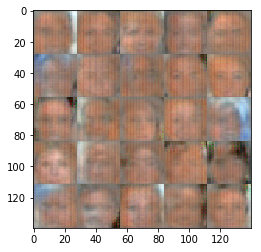

Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.8970... Generator Loss: 0.3509
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 1.5196
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 1.1897


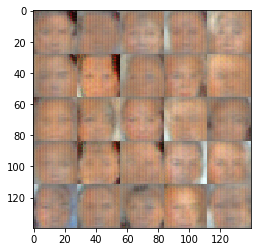

Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.7829


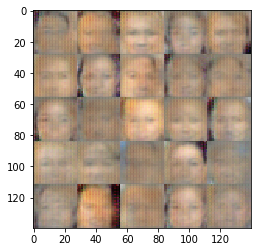

Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.8594


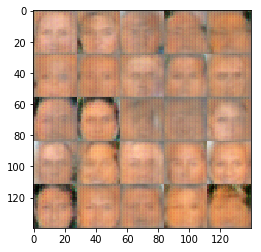

Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.6879... Generator Loss: 1.6705
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.5881


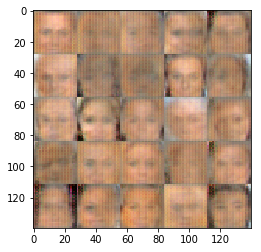

Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 1.3587
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7040


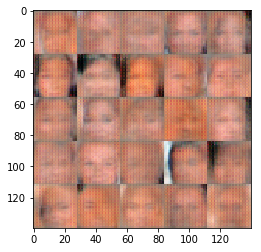

Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.4222
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.8836


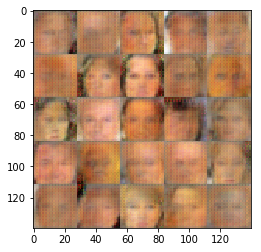

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.4478
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7779


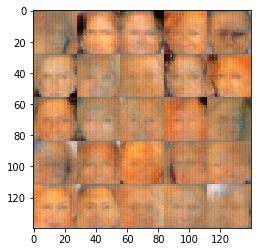

Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 2.0934
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.9504


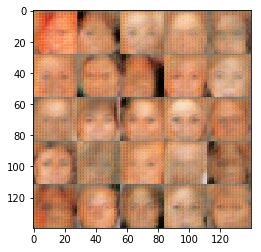

Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 1.4254


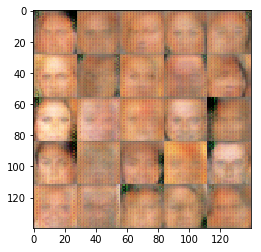

Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 1.3852
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.0570


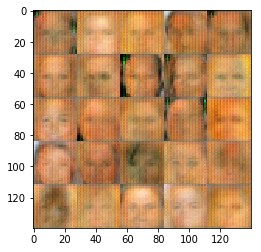

Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 1.3412
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.5427


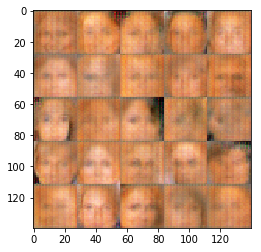

Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.3968
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 1.0127


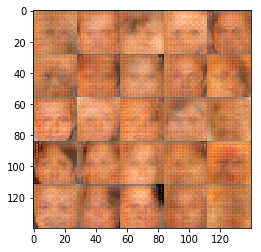

Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8474


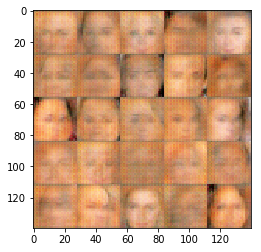

Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7118


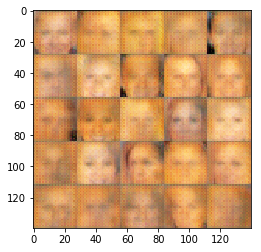

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.8262


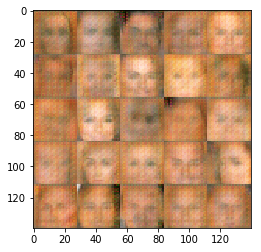

Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 1.0574


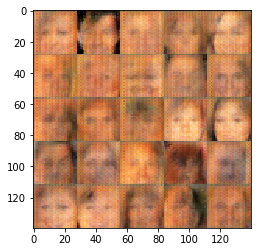

Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 1.1398


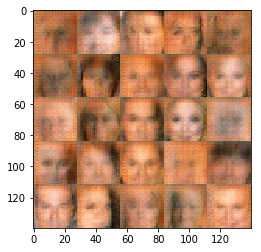

Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.6749


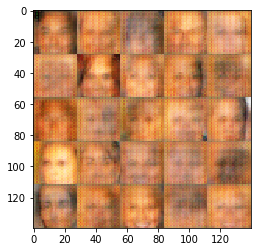

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5492


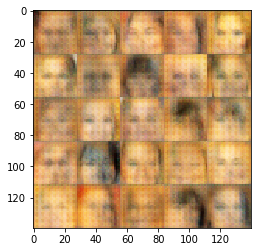

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.9382


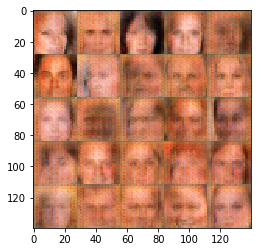

Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.0819


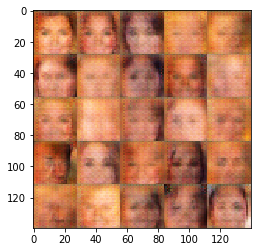

Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 1.0821


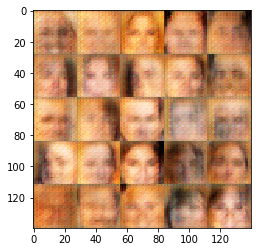

Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.9111


IndexError: list index out of range

In [91]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.